In [ ]:
import sklearn.model_selection
from sklearn.preprocessing import OneHotEncoder
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math
import statistics
import random
import seaborn as sns
from tqdm import tqdm
import copy

In [ ]:
def preprocess_data(df, class_column, normalize=True):
  df = df.copy()

  class_col = df.pop(class_column)
  df['class'] = class_col

  if normalize:
    for col in df.columns:
      if col != 'class':
        max_val = df[col].max()
        min_val = df[col].min()
        df[col] = (df[col] - min_val) / (max_val - min_val)

  ohe = OneHotEncoder()
  class_encoded = ohe.fit_transform(df[['class']]).toarray()
  class_encoded_df = pd.DataFrame(class_encoded)

  df = df.drop(columns=['class']).reset_index(drop=True)
  df = df.join(class_encoded_df)

  return df


In [ ]:
house_votes_data = pd.read_csv("house_votes_84.csv")
wine_data = pd.read_csv("wine.csv", sep="\t")
cancer_data = pd.read_csv("cancer.csv", sep="\t")

wine_data_processed = preprocess_data(wine_data, class_column = "# class", normalize = True)
cancer_data_processed = preprocess_data(cancer_data, class_column = "Class", normalize = True)

ohe = OneHotEncoder()
transformed_house_votes = ohe.fit_transform(house_votes_data).toarray()
house_votes_data_processed = pd.DataFrame(data = transformed_house_votes)

In [ ]:
house_votes_data

In [ ]:
wine_data

In [ ]:
cancer_data

In [ ]:
class NeuralNetwork:

  def __init__(self, layers, alpha, regularizer, epochs, k_folds, data):
    """Initialize a neural network.

    Parameters:
    - layers: list of ints representing number of neurons in each layer.
    - alpha: learning rate.
    - regularizer: L2 regularization parameter.
    - epochs: number of training epochs.
    - k_folds: number of folds for cross-validation.
    - data: pandas DataFrame with training features and one-hot encoded labels.
    """

    self.layers = layers
    self.alpha = alpha
    self.regularizer = regularizer
    self.epochs = epochs
    self.k_folds = k_folds
    self.data = data
    self.n_layers = len(self.layers)
    self.X = self.data.iloc[:,:-layers[-1]]
    self.Y = self.data.iloc[:,-layers[-1]:]
    self.J = 0
    self.weights = []

    self.training_losses = []
    self.test_losses = []
    self.test_accuracies = []
    self.test_precisions = []
    self.test_recalls = []
    self.test_f1s = []
    self.final_confusion_matrix = None

    self.initialize_weights()


  def initialize_weights(self):
    """Randomly initialize weights for all layers, including bias weights.

    Returns:
    - List of numpy arrays, one for each layer's weights.
    """

    for layer in range(self.n_layers-2):
      self.weights.append(np.random.randn(self.layers[layer + 1], self.layers[layer] + 1))
    self.weights.append(np.random.randn(self.layers[self.n_layers-1], self.layers[self.n_layers-2] + 1))

    return self.weights


  def sigmoid(self, x):
    """Sigmoid activation function."""

    return 1 / (1 + np.exp(-x))


  def forward(self, X):
    """Performs forward propagation.

    Parameters:
    - X: input feature vector.

    Returns:
    - Z: list of pre-activation values.
    - A: list of activations.
    - last_activation: final output vector.
    """

    x = X.copy()
    A = []
    Z = []

    current_activation = np.concatenate(([1], x))
    A.append(current_activation)

    for i in range(len(self.weights)-1):

      z = np.dot(self.weights[i], current_activation)
      Z.append(z)

      current_activation = self.sigmoid(z)
      current_activation = np.concatenate(([1.0], current_activation))

      A.append(current_activation)

    last_layer_z = np.dot(self.weights[-1], A[-1])
    Z.append(last_layer_z)

    last_activation = self.sigmoid(last_layer_z)
    A.append(last_activation)

    return Z, A, last_activation


  def calculate_loss(self, outputs, y):
    """Computes binary cross-entropy loss."""

    loss = -1 * np.multiply(y, np.log(outputs)) - np.multiply((1 - y), np.log(1 - outputs)) #this might run into problems when y is multiple classes
    return np.sum(loss)


  def back_prop(self, X, Y):
    """Performs backpropagation and update weights.

    Parameters:
    - X: input features.
    - Y: true labels.

    Returns:
    - error: list of error vectors.
    - D: list of unregularized gradient matrices.
    - regularized_gradients: list of regularized gradient matrices.
    """

    x = X.copy()#.to_numpy()
    y = Y.copy()#.to_numpy()

    error = []
    D = []
    regularized_gradients = []

    Z, A, output = self.forward(x)

    output_error = np.subtract(output, y)
    error.append(output_error)

    self.J += np.sum(self.calculate_loss(output, y)) #adds the loss for the current training instance to the J class variable

    for layer in range(self.n_layers - 2, -1, -1):

      layer_error_with_bias = np.dot(self.weights[layer].T, error[-1]) * A[layer] * (1 - A[layer])
      layer_error = np.delete(layer_error_with_bias, 0)

      gradient_matrix = np.dot(error[-1].reshape((-1, 1)), A[layer].reshape((1, -1)))
      error.append(layer_error)

      regularized_weights = self.regularizer * self.weights[layer]  #P matrix
      regularized_weights[:,0] = 0    #sets first column to 0

      D.append(gradient_matrix)

      P = np.add(gradient_matrix, regularized_weights) #P is the regularized gradient matrix, #adds D + P(regularized weights)
      regularized_gradients.append(P)

      self.weights[layer] = np.subtract(self.weights[layer], self.alpha * P) #gradient descent on the weights

    return error[:-1], D, regularized_gradients



  def regularize_loss(self, weight_list, loss, n_training_instances, regularizer):

    weights_copy = weight_list.copy()

    S = 0

    for weight_matrix in weights_copy:

      weight_matrix[:,0] = 0      #first column of every weight matrix is bias, so set it to 0
      S = np.sum(np.square(weight_matrix)) #sum of squared weights

    regularized_loss = loss / n_training_instances + regularizer / (2 * n_training_instances) * S
    return regularized_loss


  def fit(self, test_size = 0.3, shuffle = True):

    n_outputs = self.layers[-1]
    X = self.X
    Y = self.Y

    train_x, test_x, train_y, test_y = sklearn.model_selection.train_test_split(X, Y, test_size = test_size, shuffle = shuffle)

    return train_x, train_y, test_x, test_y


  def SGD(self, train_x, train_y, test_x = None, test_y = None):

    self.training_losses = []
    self.test_losses = []
    self.test_accuracies = []
    self.test_precisions = []
    self.test_recalls = []
    self.test_f1s = []
    self.confusion_matrix = np.zeros((self.layers[-1], self.layers[-1]))

    x_train_np = train_x.to_numpy()
    y_train_np = train_y.to_numpy()

    n_training_instances = x_train_np.shape[0]

    for i in range(self.epochs):

      self.J = 0 #resets the loss every epoch

      for i in range(n_training_instances):

        x = x_train_np[i]
        y = y_train_np[i]
        instance_loss = self.back_prop(x, y)

      epoch_loss = self.regularize_loss(self.weights, self.J, n_training_instances, self.regularizer)
      self.training_losses.append(epoch_loss)

      if test_x is not None and test_y is not None:
        test_loss, accuracy, precision, recall, f1, confusion_matrix = self.evaluate_on_test_set(test_x, test_y)
        self.test_losses.append(test_loss)
        self.test_accuracies.append(accuracy)
        self.test_precisions.append(precision)
        self.test_recalls.append(recall)
        self.test_f1s.append(f1)

    self.final_confusion_matrix = confusion_matrix
    final_metrics = (self.test_accuracies[-1], self.test_precisions[-1], self.test_recalls[-1], self.test_f1s[-1], self.test_losses[-1])

    return final_metrics


  def predict(self, test_instance):

    _, _, output = self.forward(test_instance)

    prediction = np.zeros(len(output))
    prediction[np.argmax(output)] = 1

    return output, prediction


  def confusion_matrix_metrics(self, cm): #calculates precision, recall, F1 score from the confusion matrix

    num_classes = cm.shape[0]
    eps = 1e-8  #small value to avoid division by zero

    precisions = []
    recalls = []
    f1s = []

    for i in range(num_classes):
        TP = cm[i, i]
        FP = np.sum(cm[:, i]) - TP
        FN = np.sum(cm[i, :]) - TP

        precision = TP / (TP + FP + eps)
        recall = TP / (TP + FN + eps)
        f1 = 2 * precision * recall / (precision + recall + eps)

        precisions.append(precision)
        recalls.append(recall)
        f1s.append(f1)

    return np.mean(precisions), np.mean(recalls), np.mean(f1s)


  def evaluate_on_test_set(self, test_x, test_y):

    test_x_np = test_x.to_numpy()
    test_y_np = test_y.to_numpy()

    n_test = test_x_np.shape[0]
    correct = 0
    test_loss = 0
    confusion_matrix = np.zeros((self.layers[-1], self.layers[-1]))

    for i in range(n_test):
      output, prediction = self.predict(test_x_np[i])
      actual = test_y_np[i]

      test_loss += np.sum(self.calculate_loss(output, actual))

      actual_index = np.argmax(actual)
      confusion_matrix[actual_index] += prediction

      if np.array_equal(prediction, actual):
          correct += 1

    accuracy = correct / n_test
    precision, recall, f1 = self.confusion_matrix_metrics(confusion_matrix)

    return test_loss, accuracy, precision, recall, f1, confusion_matrix


  def stratify_data(self, k):

    df = self.data.copy()
    n = df.shape[0]

    n_outputs = self.layers[-1]
    folds = [pd.DataFrame() for _ in range(k)]

    y = df.iloc[:,-n_outputs:].idxmax(axis=1)
    x = df.iloc[:,:-n_outputs]
    a = x.join(y.rename('class'))

    classes = pd.unique(a['class'])
    class_dfs = [a[a['class'] == c] for c in classes]

    for class_df in range(n_outputs):

      new = np.array_split(class_dfs[class_df], k)

      for fold in range(k):
        folds[fold] = pd.concat([folds[fold], new[fold]]).sample(frac=1)

    return folds


  def re_hot_encode_class_column(self, df):  #not efficient at all but it works

    n_outputs = self.layers[-1]
    ohe = OneHotEncoder()

    transformed_class = ohe.fit_transform(df[['class']]).toarray()
    temp_df = pd.DataFrame(data = transformed_class).reset_index(drop = True)
    transformed_df = df.drop(columns = ['class']).reset_index(drop = True).join(temp_df, how = 'left', lsuffix='left', rsuffix='right')

    return transformed_df


  def stratified_metrics(self):

    fold_data = self.stratify_data(self.k_folds)
    n_outputs = self.layers[-1]

    accuracy_list = []
    precision_list = []
    recall_list = []
    F1_list = []

    for i in range(len(fold_data)):
      testing_fold = self.re_hot_encode_class_column(fold_data[i])
      k_minus1_fold_data = fold_data[:i] + fold_data[i+1:]

      training_data = self.re_hot_encode_class_column(pd.concat(k_minus1_fold_data))

      train_x = training_data.iloc[:,:-n_outputs]
      train_y = training_data.iloc[:,-n_outputs:]
      test_x = testing_fold.iloc[:,:-n_outputs]
      test_y = testing_fold.iloc[:,-n_outputs:]

      #RE INITIALIZE WEIGHTS AFTER EVERY FOLD

      accuracy, precision, recall, F1 = self.SGD(train_x=train_x, train_y=train_y, test_x=test_x, test_y=test_y)

      self.weights = []
      self.initialize_weights()

      accuracy_list.append(accuracy)
      precision_list.append(precision)
      recall_list.append(recall)
      F1_list.append(F1)

    return np.mean(accuracy_list), np.mean(precision_list), np.mean(recall_list), np.mean(F1_list)






In [ ]:
def evaluate_networks(dataset, architectures, alphas, regularizers, epochs, k_folds, test_size=0.3, stratify=False, sort_by = 'F1'):
    results = []

    for layers in tqdm(architectures, desc = "Layer Configurations"):
      for alpha in alphas:
        for regularizer in regularizers:
          model = NeuralNetwork(layers=layers, alpha=alpha, regularizer=regularizer, epochs=epochs, k_folds=k_folds, data=dataset)

          if stratify:
            acc, prec, rec, f1 = model.stratified_metrics()
          else:
            train_x, train_y, test_x, test_y = model.fit(test_size=test_size, shuffle=True)
            acc, prec, rec, f1, _ = model.SGD(train_x=train_x, train_y=train_y, test_x=test_x, test_y=test_y)

          results.append([len(layers)-2, str(layers), alpha, round(regularizer, 6), epochs, k_folds, test_size, round(acc, 4), round(prec, 4), round(rec, 4), round(f1, 4), stratify])

    columns = ['Num Hidden Layers', 'Architecture', 'Alpha', 'Regularizer', 'Epochs', 'Folds', 'Test Size', 'Accuracy', 'Precision', 'Recall', 'F1', 'Stratified']
    results = pd.DataFrame(results, columns = columns)

    if sort_by in columns:
      results = results.sort_values(by = sort_by, ascending = False).reset_index(drop = True)

    return results


def plot_training_metrics(model, metrics=["loss", "accuracy", "precision", "recall", "f1", "confusion_matrix"]):

  epochs = range(1, model.epochs + 1)
  plot_metrics = [m for m in metrics if m != "confusion_matrix"]

  fig, axs = plt.subplots(1, len(plot_metrics), figsize=(6 * len(plot_metrics), 5))
  axs = np.atleast_1d(axs)

  for ax, metric in zip(axs, plot_metrics):
    if metric == "loss":
      ax.plot(epochs, model.training_losses, label="Training Loss")
      ax.plot(epochs, model.test_losses, label="Test Loss")
      ax.set_title("Loss over Epochs")
    elif metric == "accuracy":
      ax.plot(epochs, model.test_accuracies, label="Accuracy")
      ax.set_title("Test Accuracy over Epochs")
    elif metric == "precision":
      ax.plot(epochs, model.test_precisions, label="Precision")
      ax.set_title("Test Precision over Epochs")
    elif metric == "recall":
      ax.plot(epochs, model.test_recalls, label="Recall")
      ax.set_title("Test Recall over Epochs")
    elif metric == "f1":
      ax.plot(epochs, model.test_f1s, label="F1 Score")
      ax.set_title("Test F1 Score over Epochs")

    ax.set_xlabel("Epoch")
    ax.set_ylabel(metric.capitalize())
    ax.legend()
    ax.grid(True)

  if "confusion_matrix" in metrics:
    plt.figure(figsize=(6, 5))
    sns.heatmap(model.final_confusion_matrix, annot = True, fmt=".1f", cmap = "Blues", cbar = False)
    plt.title("Final Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")

  plt.tight_layout()
  plt.show()


def plot_learning_curve(model, min_frac=0.1, max_frac=0.9, steps=9):
    """
    Plot number of training instances vs. test loss for a given NeuralNetwork model.

    Parameters:
    - model: an initialized (but not yet trained) NeuralNetwork instance.
    - min_frac: minimum training size fraction (e.g. 0.1)
    - max_frac: maximum training size fraction (e.g. 0.9)
    - steps: number of fractional steps to test (default 9 for 0.1 to 0.9)
    """

    train_sizes = np.linspace(min_frac, max_frac, steps)
    test_losses = []

    for frac in tqdm(train_sizes, desc = "Training Size"):

      model_copy = copy.deepcopy(model)

      train_x, train_y, test_x, test_y = model_copy.fit(test_size = 1 - frac, shuffle = True)
      model_copy.SGD(train_x=train_x, train_y=train_y, test_x=test_x, test_y=test_y)
      test_losses.append(model_copy.test_losses[-1])  #last epoch test loss

    plt.figure(figsize=(8, 5))
    plt.plot((train_sizes * len(model.data)), test_losses, marker='o')
    plt.xlabel("Number of Training Instances")
    plt.ylabel("Test Loss")
    plt.title("Training Set Size vs. Test Loss")
    plt.grid(True)
    plt.tight_layout()
    plt.show()




In [ ]:
nn = NeuralNetwork(layers = [48, 16, 8, 4, 2], alpha = 0.01, regularizer = 0.01, epochs = 50, k_folds = 10, data = house_votes_data_processed)

train_x, train_y, test_x, test_y = nn.fit(test_size=0.3, shuffle=True)
nn.SGD(train_x=train_x, train_y=train_y, test_x=test_x, test_y=test_y)

#nn.stratified_metrics()


(0.9541984732824428,
 np.float64(0.9476543208354502),
 np.float64(0.9550702809673338),
 np.float64(0.9510950670220865),
 np.float64(40.41373998508305))

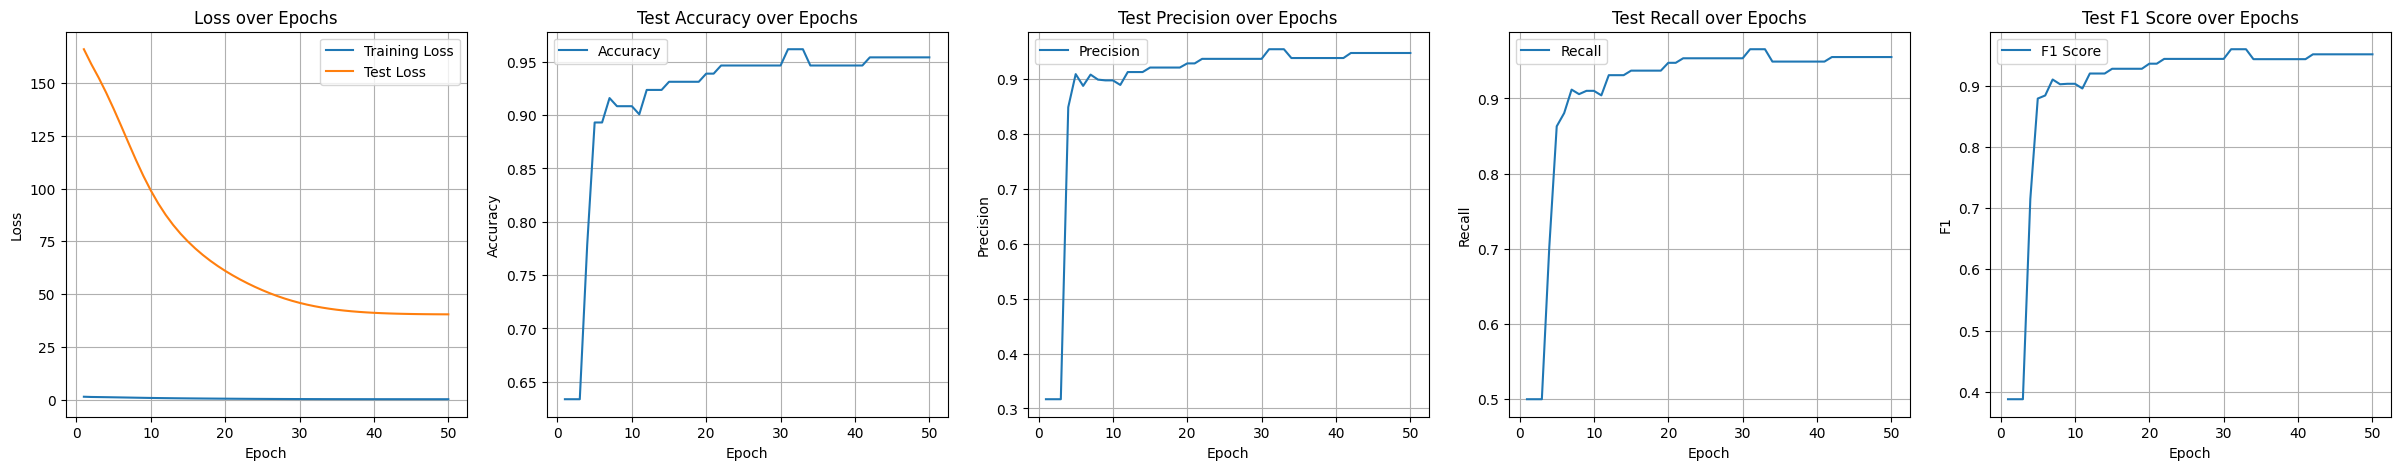

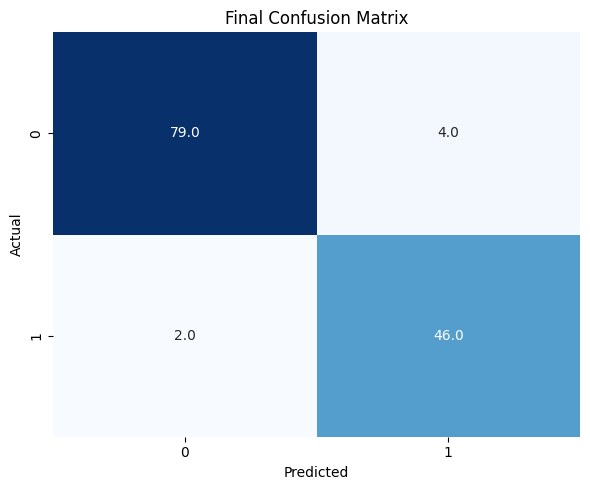

Training Size: 100%|██████████| 9/9 [00:26<00:00,  3.00s/it]


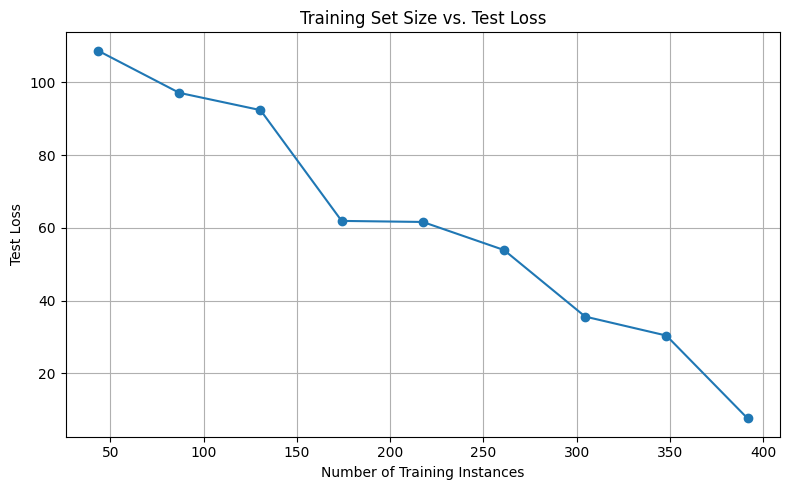

In [ ]:
plot_training_metrics(nn)
plot_learning_curve(nn)

In [ ]:
house_votes_data_processed.shape

(435, 50)

In [ ]:
layer_configs = [
    [48, 8, 2],
    [48, 4, 2],
    [48, 16, 8, 4, 2],
    [48, 10, 7, 4, 2],
    [48, 32, 16, 8, 4, 2]
]

results_df = evaluate_networks(
    dataset = house_votes_data_processed,
    architectures = layer_configs,
    alphas = [0.1, 0.01],
    regularizers = [0.00075, 0.001, 0.01, 0.1],
    epochs = 50,
    k_folds = 10,
    test_size = 0.4,
    stratify = False,
    sort_by = 'F1'
)

results_df

Layer Configurations: 100%|██████████| 5/5 [01:38<00:00, 19.65s/it]


,Num Hidden Layers,Architecture,Alpha,Regularizer,Epochs,Folds,Test Size,Accuracy,Precision,Recall,F1,Stratified
0,3,"[48, 16, 8, 4, 2]",0.01,0.01000,50,10,0.4,0.9828,0.9802,0.9831,0.9816,False
1,1,"[48, 8, 2]",0.01,0.00075,50,10,0.4,0.9770,0.9743,0.9784,0.9762,False
2,1,"[48, 4, 2]",0.10,0.00100,50,10,0.4,0.9713,0.9692,0.9731,0.9708,False
3,3,"[48, 10, 7, 4, 2]",0.01,0.00075,50,10,0.4,0.9713,0.9715,0.9701,0.9708,False
4,4,"[48, 32, 16, 8, 4, 2]",0.10,0.01000,50,10,0.4,0.9713,0.9707,0.9677,0.9692,False
5,1,"[48, 4, 2]",0.01,0.00100,50,10,0.4,0.9655,0.9665,0.9635,0.9648,False
6,3,"[48, 16, 8, 4, 2]",0.10,0.00100,50,10,0.4,0.9655,0.9621,0.9665,0.9641,False
7,1,"[48, 4, 2]",0.01,0.00075,50,10,0.4,0.9598,0.9538,0.9617,0.9574,False
8,1,"[48, 8, 2]",0.10,0.00075,50,10,0.4,0.9598,0.9558,0.9586,0.9572,False
9,4,"[48, 32, 16, 8, 4, 2]",0.10,0.00100,50,10,0.4,0.9598,0.9584,0.9555,0.9569,False


In [ ]:
results_df

,Num Hidden Layers,Architecture,Alpha,Regularizer,Epochs,K-Folds,Test Size,Accuracy,Precision,Recall,F1,Stratified
0,3,"[48, 8, 2]",0.1,0.00075,50,10,0.3,0.9618,0.9577,0.9613,0.9594,False
1,3,"[48, 4, 2]",0.1,0.00075,50,10,0.3,0.9237,0.9208,0.9208,0.9208,False


In [ ]:
'''
Wine Data: 8 Nueral Networks plus Loss Graph
'''

wine_NN_1 = NeuralNetwork(layers = [13, 8, 4, 3], alpha = 0.1, regularizer = 0.0000000, epochs = 100, k_folds = 10, data = wine_data_processed)
wine_NN_1.stratified_accuracy()

wine_NN_2 = NN(layers = [13, 8, 4, 3], alpha = 0.001, regularizer = 0.0000000, epochs = 100, k_folds = 10, data = wine_data)
#wine_NN_2.stratified_accuracy()

wine_NN_3 = NN(layers = [13, 8, 6, 4, 3], alpha = 0.1, regularizer = 0.0000000, epochs = 100, k_folds = 10, data = wine_data)
#wine_NN_3.stratified_accuracy()

wine_NN_4 = NN(layers = [13, 10, 8, 6, 4, 3], alpha = 0.1, regularizer = 0.0000000, epochs = 100, k_folds = 10, data = wine_data)
#wine_NN_4.stratified_accuracy()

wine_NN_5 = NN(layers = [13, 4, 6, 8, 3], alpha = 0.1, regularizer = 0.0000000, epochs = 100, k_folds = 10, data = wine_data)
#wine_NN_5.stratified_accuracy()

wine_NN_6 = NN(layers = [13, 8, 6, 4, 3], alpha = 0.1, regularizer = 0.00075, epochs = 100, k_folds = 10, data = wine_data)
#wine_NN_6.stratified_accuracy()

wine_NN_7 = NN(layers = [13, 16, 8, 4, 3], alpha = 0.1, regularizer = 0.00075, epochs = 100, k_folds = 10, data = wine_data)
#wine_NN_7.stratified_accuracy()

wine_NN_8 = NN(layers = [13, 10, 7, 4, 3], alpha = 0.1, regularizer = 0.00075, epochs = 100, k_folds = 10, data = wine_data)
#wine_NN_8.stratified_accuracy()


'''
train_data, test_data = sklearn.model_selection.train_test_split(wine_data, test_size = 0.3, train_size = 0.7, shuffle = True)

train_x = train_data.iloc[:,:-3]
train_y = train_data.iloc[:,-3:]
test_x = test_data.iloc[:,:-3]
test_y = test_data.iloc[:,-3:]

test_loss = []
n_training_instance_list = np.arange(10, 180, 10)
n_training_instance_list = np.concatenate(([2, 5], n_training_instance_list))

for i in range(len(n_training_instance_list)):
  current_training_set_x = train_x.iloc[:n_training_instance_list[i]]
  current_training_set_y = train_y.iloc[:n_training_instance_list[i]]

  acc, F1, loss = wine_NN_8.accuracy(current_training_set_x, current_training_set_y, test_x, test_y)
  test_loss.append(loss)


plt.plot(n_training_instance_list, test_loss)
plt.ylabel("Test Loss")
plt.xlabel("Number of training instances")
plt.title('Number of Taining Instances VS Testing Loss')
plt.show()
'''




/usr/local/lib/python3.11/dist-packages/numpy/_core/fromnumeric.py:57: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


NameError: name 'NN' is not defined

/usr/local/lib/python3.11/dist-packages/numpy/_core/fromnumeric.py:57: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


(np.float64(0.9582855129366757), np.float64(0.955874857093816))


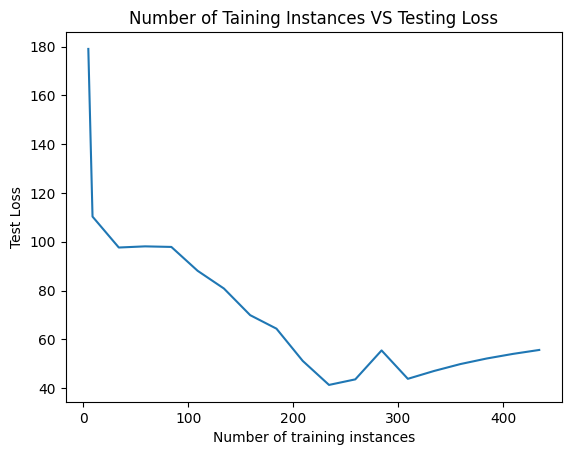

In [ ]:
'''
House Votes Dataset: 7 Neural Networks plus Loss graph
'''

house_votes_NN_1 = NeuralNetwork(layers = [48, 8, 2], alpha = 0.1, regularizer = 0.0, epochs = 50, k_folds = 10, data = house_votes_data)
#print(house_votes_NN_1.stratified_accuracy())

house_votes_NN_2 = NeuralNetwork(layers = [48, 3, 2], alpha = 0.1, regularizer = 0.0, epochs = 50, k_folds = 10, data = house_votes_data)
#print(house_votes_NN_2.stratified_accuracy())

house_votes_NN_3 = NeuralNetwork(layers = [48, 30, 2], alpha = 0.1, regularizer = 0.0, epochs = 50, k_folds = 10, data = house_votes_data)
#print(house_votes_NN_3.stratified_accuracy())

house_votes_NN_4 = NeuralNetwork(layers = [48, 10, 7, 4, 2], alpha = 0.1, regularizer = 0.0, epochs = 50, k_folds = 10, data = house_votes_data)
#print(house_votes_NN_4.stratified_accuracy())

house_votes_NN_5 = NeuralNetwork(layers = [48, 8, 2], alpha = 0.1, regularizer = 0.005, epochs = 50, k_folds = 10, data = house_votes_data)
#print(house_votes_NN_5.stratified_accuracy())

house_votes_NN_6 = NeuralNetwork(layers = [48, 8, 4, 2], alpha = 0.1, regularizer = 0.00, epochs = 50, k_folds = 10, data = house_votes_data)
#print(house_votes_NN_6.stratified_accuracy())

house_votes_NN_7 = NeuralNetwork(layers = [48, 8, 2], alpha = 0.05, regularizer = 0.000, epochs = 10, k_folds = 10, data = house_votes_data_processed)
print(house_votes_NN_7.stratified_accuracy())



htrain_data, htest_data = sklearn.model_selection.train_test_split(house_votes_data_processed, test_size = 0.3, train_size = 0.7, shuffle = True)


htrain_x = htrain_data.iloc[:,:-2]
htrain_y = htrain_data.iloc[:,-2:]
htest_x = htest_data.iloc[:,:-2]
htest_y = htest_data.iloc[:,-2:]


test_loss = []
n_training_instance_list = np.arange(9, 450, 25)
n_training_instance_list = np.concatenate(([5], n_training_instance_list))

for i in range(len(n_training_instance_list)):
  current_training_set_x = htrain_x.iloc[:n_training_instance_list[i]]
  current_training_set_y = htrain_y.iloc[:n_training_instance_list[i]]

  acc, F1, loss = house_votes_NN_7.accuracy(current_training_set_x, current_training_set_y, htest_x, htest_y)
  test_loss.append(loss)


plt.plot(n_training_instance_list, test_loss)
plt.ylabel("Test Loss")
plt.xlabel("Number of training instances")
plt.title('Number of Taining Instances VS Testing Loss')
plt.show()


(435, 50)

In [ ]:
'''
Breast Cancer Dataset: 8 Neural Networks plus Loss graph
'''

cancer_NN_1 = NN(layers = [9, 6, 4, 2], alpha = 0.05, regularizer = 0.01, epochs = 50, k_folds = 10, data = cancer_data)
#print(cancer_NN_1.stratified_accuracy())

cancer_NN_2 = NN(layers = [9, 6, 4, 2], alpha = 0.05, regularizer = 0.00, epochs = 50, k_folds = 10, data = cancer_data)
#print(cancer_NN_2.stratified_accuracy())

cancer_NN_3 = NN(layers = [9, 5, 2], alpha = 0.05, regularizer = 0.00, epochs = 50, k_folds = 10, data = cancer_data)
#print(cancer_NN_3.stratified_accuracy())

cancer_NN_4 = NN(layers = [9, 8, 2], alpha = 0.05, regularizer = 0.00, epochs = 50, k_folds = 10, data = cancer_data)
#print(cancer_NN_3.stratified_accuracy())

cancer_NN_5 = NN(layers = [9, 3, 2], alpha = 0.05, regularizer = 0.00, epochs = 50, k_folds = 10, data = cancer_data)
#print(cancer_NN_5.stratified_accuracy())

cancer_NN_6 = NN(layers = [9, 12, 8, 4, 2], alpha = 0.05, regularizer = 0.00, epochs = 50, k_folds = 10, data = cancer_data)
#print(cancer_NN_6.stratified_accuracy())

cancer_NN_7 = NN(layers = [9, 12, 8, 4, 2], alpha = 0.025, regularizer = 0.00, epochs = 50, k_folds = 10, data = cancer_data)
#print(cancer_NN_7.stratified_accuracy())

cancer_NN_8 = NN(layers = [9, 10, 7, 4, 2], alpha = 0.05, regularizer = 0.00, epochs = 50, k_folds = 10, data = cancer_data)
#print(cancer_NN_8.stratified_accuracy())


ctrain_data, ctest_data = sklearn.model_selection.train_test_split(cancer_data, test_size = 0.3, train_size = 0.7, shuffle = True)

ctrain_x = ctrain_data.iloc[:,:-2]
ctrain_y = ctrain_data.iloc[:,-2:]
ctest_x = ctest_data.iloc[:,:-2]
ctest_y = ctest_data.iloc[:,-2:]

test_loss = []
n_training_instance_list = np.arange(23, 401, 25)
n_training_instance_list = np.concatenate(([5, 15], n_training_instance_list))

for i in range(len(n_training_instance_list)):
  current_training_set_x = ctrain_x.iloc[:n_training_instance_list[i]]
  current_training_set_y = ctrain_y.iloc[:n_training_instance_list[i]]

  acc, F1, loss = cancer_NN_6.accuracy(current_training_set_x, current_training_set_y, ctest_x, ctest_y)
  test_loss.append(loss)


plt.plot(n_training_instance_list, test_loss)
plt.ylabel("Test Loss")
plt.xlabel("Number of training instances")
plt.title('Number of Taining Instances VS Testing Loss')
plt.show()





KeyboardInterrupt: 